In [230]:
import sys
sys.argv = ['']
sys.path.append("../..")

from src.grid_world import GridWorld
import numpy as np
import random

In [231]:
class MonteCarlo:
    def __init__(self, env, iterations, episodes_steps, episode_length, gamma=0.9, epsilon=0.1):
        """
        Monte Carlo Basic Policy Iteration for a GridWorld environment.
        """
        self.env = env
        self.gamma = gamma
        self.iterations = iterations
        self.epsilon = epsilon

        self.episodes_steps = episodes_steps
        self.episode_length = episode_length

        self.num_states = env.num_states
        self.num_actions = len(env.action_space)
        self.action_space = env.action_space

        self.V = np.zeros(self.num_states)
        self.Q = np.zeros((self.num_states, self.num_actions))
        self.policy = np.ones((self.num_states, self.num_actions)) / self.num_actions

    def state2idx(self, state):
        return state[0]*self.env.env_size[0]+state[1]

    def idx2state(self, idx):
        x = idx % self.env.env_size[0]
        y = idx // self.env.env_size[0]
        return x, y

    def action2idx(self, action):
        return self.action_space.index(action)

    def idx2action(self, idx):
        return self.action_space[idx]

    def generate_episode(self, start_state_idx, start_action_idx):
        """
        Generate an episode following current policy π.
        Returns the list of (s,a,r) and total discounted return.
        """
        s_idx = start_state_idx
        a_idx = start_action_idx
        s = self.idx2state(s_idx)
        a = self.idx2action(a_idx)

        episode_list = []
        total_return = 0.0

        for t in range(self.episode_length):
            next_state, reward = self.env._get_next_state_and_reward(s, a)
            episode_list.append((s_idx, a_idx, reward))
            total_return += (self.gamma ** t) * reward

            if next_state != self.env.target_state:
                s_idx = self.state2idx(next_state)
                s = next_state
                a_idx = self.choose_action(s_idx)
                a = self.idx2action(a_idx)

        return episode_list, total_return

    def choose_action(self, state_idx):
        """
        Choose an action according to current policy (epsilon-soft)
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            max_value = np.max(self.Q[state_idx])
            best_actions = np.where(self.Q[state_idx] == max_value)[0]
            return np.random.choice(best_actions)

    def iteration(self):
        """
        Run MC Basic Policy Iteration
        """
        for it in range(self.iterations):
            for s in range(self.num_states):
                for a in range(self.num_actions):
                    returns = []
                    for ep in range(self.episodes_steps):
                        _, r = self.generate_episode(s, a)
                        returns.append(r)
                    # Policy evaluation: average return over multiple episodes
                    self.Q[s, a] = np.mean(returns)

                # Policy improvement: greedy wrt Q
                max_value = np.max(self.Q[s])
                best_actions = np.where(self.Q[s] == max_value)[0]
                chosen_action = np.random.choice(best_actions)

                self.V[s] = self.Q[s, chosen_action]

                for i in range(self.num_actions):
                    self.policy[s][i] = 1.0 if i == chosen_action else 0.0
            print("iteration %d done" % it)

    def render(self, precision=1):
        """
        Render the GridWorld with the optimal value function and policy.
        """
        self.env.render_static(values=self.V, policy=self.policy, precision=precision)


iteration 0 done


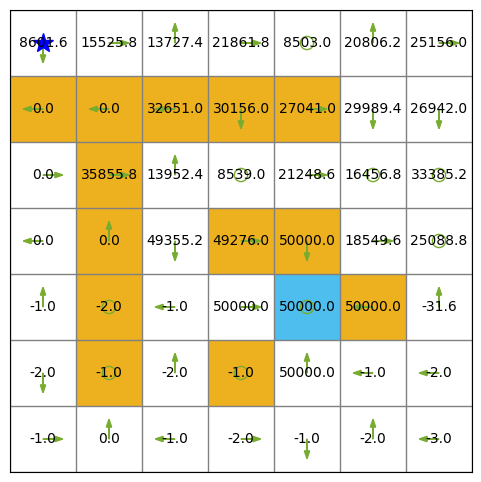

In [232]:
env = GridWorld()
env.reward_target = 100
env.reward_step = -1
env.reward_forbidden = 0
env.reset()
agent = MonteCarlo(env, iterations=1, episodes_steps=5, episode_length=500, gamma=1, epsilon=0)
agent.iteration()
agent.render()

iteration 0 done
iteration 1 done
iteration 2 done
iteration 3 done
iteration 4 done
iteration 5 done
iteration 6 done
iteration 7 done
iteration 8 done
iteration 9 done


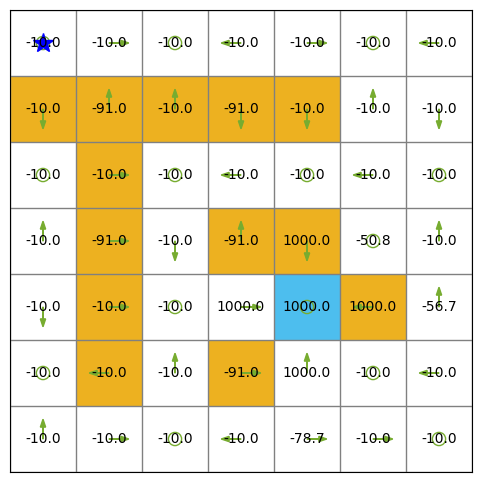

In [233]:
env = GridWorld()
env.reward_target = 100
env.reward_step = -1
env.reward_forbidden = -10
env.reset()
agent = MonteCarlo(env, iterations=10, episodes_steps=5, episode_length=250, gamma=0.9, epsilon=0)
agent.iteration()
agent.render()